In [35]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from IPython.display import Audio, display
def allDone():
    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
import corner
import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import pickle
import h5py
import scipy
from matplotlib.pyplot import GridSpec

In [36]:
def get_spectrum(source_id):
    path = wdtable[wdtable['source_id'] == source_id][0]['specpath']
    try:
        f = fits.open(path)
        flux = f[1].data['flux']
        loglam = f[1].data['loglam']
        f.close()
        lam = 10**loglam
    except:
        print('Spectrum file missing...')
        return
    return lam,flux

In [37]:
filetable = Table.read('filetable.fits')
wdtable = Table.read('tremblay_final.fits')
print(len(wdtable))
wdtable = join(filetable,wdtable,keys = ['source_id'])

DA = (wdtable['spectral_class_1'] == 'DA')
wdtable = wdtable[DA]
print(len(wdtable))

5396
5366


In [38]:
pixels = np.arange(0,4000)
continuum = (pixels > 2900) + (pixels < 2200)*(pixels > 1200) + (pixels < 650)*(pixels > 530) \
            + (pixels < 35)*(pixels > 20) + (pixels < 220)*(pixels > 200)

def adapted_ch_cont(lam,flux,continuum,sigarray = None):
    spec = flux.astype(np.float64)
    lam = lam.astype(np.float64)
    notnan = ~np.isnan(spec) * ~np.isnan(lam)
    p = np.polynomial.chebyshev.chebfit(lam[continuum*notnan],medfilt(spec,5)[continuum*notnan],8)
    cont = np.polynomial.chebyshev.chebval(lam,p)
    contcorr = spec / cont
    if sigarray is not None:
        stdev = np.sqrt(1.0/sigarray)
        contsigarray = stdev / cont
        normivar = (1.0/contsigarray)**2
        return contcorr,normivar
    skylinemask = (lam > 5578.5 - 10)*(lam < 5578.5 + 10) + (lam > 5894.6 - 10)*(lam < 5894.6 + 10)\
        + (lam > 6301.7 - 10)*(lam < 6301.7 + 10) + (lam > 7246.0 - 10)*(lam < 7246.0 + 10)
    contcorr[skylinemask] = 1
#     plt.plot(contcorr)
    return contcorr

def linear(wl,p1,p2):
    return p1 + p2*wl

def pv(l,lgamma,ggamma,centre,scale):
        
    Gamma = (ggamma**5 + 2.69269*ggamma**4 * lgamma + 2.42843*\
            ggamma**3 * lgamma**2 + 4.47163*lgamma**3 * ggamma**2 + \
            0.07842*ggamma * lgamma**4 + lgamma**5)**(1/5)
        
    neta = 1.36603*(lgamma/Gamma) - 0.47719*(lgamma/Gamma)**2 + 0.11116*(lgamma/Gamma)**3
        
    profile = 1 - scale * (neta*(1/(np.pi * lgamma)) * (lgamma**2) / ( (l-centre)**2 + lgamma**2 ) + (1-neta)*\
                           (1/np.sqrt(2*np.pi*ggamma**2)) * np.exp(-(l-centre)**2/(2*ggamma**2)))
    where = np.isnan(profile)
    profile[where] = 1
    profile = scipy.ndimage.filters.gaussian_filter1d(profile,5)
    return profile

def chisquare(residual):
    return np.sum(residual**2)

def fit_line(lam,flux,centroid):

    in1 = bisect_left(lam,centroid-150)
    in2 = bisect_left(lam,centroid+150)
    clam = lam[in1:in2]
    cflux = flux[in1:in2]

    cmask = (clam < centroid - 75)+(clam > centroid + 75)
    
    
    
    plt.plot(clam,cflux)
    plt.plot(clam[cmask],cflux[cmask])

    p,cov = curve_fit(linear,clam[cmask],cflux[cmask])

    plt.plot(clam,linear(clam,p[0],p[1]))

    contcorr = cflux / linear(clam, p[0], p[1])
    #contcorr = -cflux + 1
    
    plt.figure()
    plt.plot(contcorr)
    

    voigtfitter = lmfit.models.VoigtModel()
    params = voigtfitter.make_params()
    params['amplitude'].set(min = 0,max = 100,value = 25)
    params['center'].set(value = centroid)
    params['sigma'].set(min = 0,max=200,value=10)
    params['gamma'].set(value=10,min = 0,max=200,vary=True)
    
    result = voigtfitter.fit(contcorr,params,x = clam,nan_policy = 'omit',method='dual_annealing',\
                             fit_kws={'reduce_fcn':chisquare})

    
#     plt.figure(figsize=(10,5))
#     plt.title(str(centroid)+"$\AA$")
#     plt.plot(clam,-contcorr,'k')
#     plt.plot(clam,-voigtfitter.eval(result.params,x=clam),'r')
#     plt.plot(clam,-voigtfitter.eval(params,x=clam),'k--')
#     plt.xlabel('Wavelength ($\AA$)')
#     plt.ylabel('Normalized Flux')
#     plt.show()
    return result

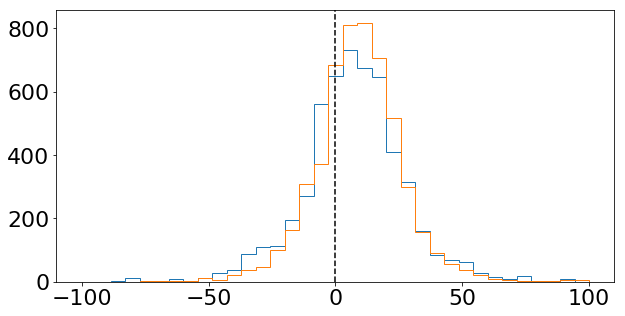

In [12]:
arv = 1e5*(alphaparameters[:,1] - halpha)/halpha
brv = 1e5*(betaparameters[:,1] - hbeta)/hbeta

plt.figure(figsize = (10,5))
plt.hist(arv,histtype='step',bins=35, range = (-100,100) )
plt.hist(brv,histtype='step',bins=35, range = (-100,100) );

mask = (~np.isnan(arv))*(~np.isnan(brv))
plt.axvline(0, color = 'k', linestyle = '--')

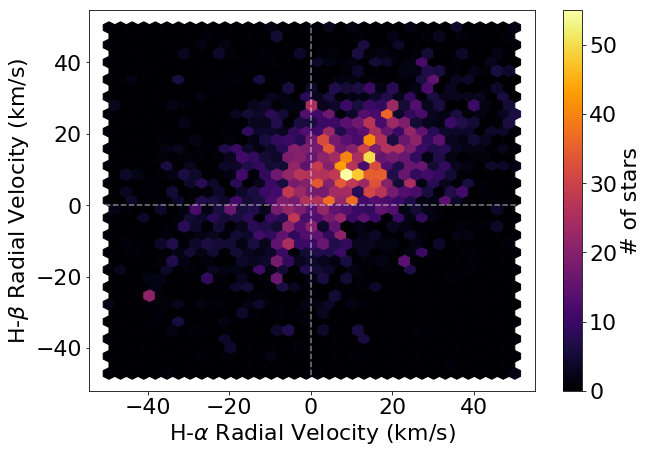

In [13]:
plt.figure(figsize = (10,7))
mask = (np.abs(arv) < 50)*(np.abs(brv) < 50)
plt.hexbin(arv[mask], brv[mask], cmap = 'inferno', gridsize = 35)
cbar = plt.colorbar()
plt.axvline(0,color = 'w', linestyle = '--', alpha = 0.5)
plt.axhline(0,color = 'w', linestyle = '--', alpha = 0.5)
plt.xlabel(r'H-$\alpha$ Radial Velocity (km/s)')
plt.ylabel(r'H-$\beta$ Radial Velocity (km/s)')
cbar.ax.set_ylabel('# of stars')
plt.savefig('gredshift.pdf')

In [23]:
import pandas as pd
import seaborn as sns

dfa = pd.DataFrame(alphaparameters, columns = ['sigma_a','center_a','amplitude_a','gamma_a','fwhm_a','height_a', 'chi2_a'])
dfb = pd.DataFrame(betaparameters, columns = ['sigma_b','center_b','amplitude_b','gamma_b','fwhm_b','height_b', 'chi2_b'])
dfg = pd.DataFrame(gammaparameters, columns = ['sigma_g','center_g','amplitude_g','gamma_g','fwhm_g','height_g', 'chi2_g'])

In [24]:
df = dfa.join(dfb).join(dfg)

In [25]:
df['Teff'] = wdtable['spec_Teff']
df['logg'] = wdtable['spec_logg']

# PREMADE DF

In [15]:
import pandas as pd

In [16]:
df = pd.read_csv('line_profiles_5366.csv')

In [17]:
clean = (

    (df['Teff'] < 40000)&
    (df['center_a'] < halpha + 25)&
    (df['center_a'] > halpha - 25)&
    (df['center_b'] < hbeta + 25)&
    (df['center_b'] > hbeta - 25)&
    (df['center_g'] < hgamma + 25)&
    (df['center_g'] > hgamma - 25)&
    (df['chi2_a'] < 0.01) & (df['chi2_b'] < 0.01) & (df['chi2_g'] < 0.01)&
    (df['fwhm_a'] < 100)&
    (df['fwhm_b'] < 100)&
    (df['fwhm_g'] < 100)
#     (df['sigma_a'] < 0.2)&
#     (df['sigma_b'] < 0.2)&
#     (df['sigma_g'] < 0.2)

)

In [18]:
print(len(df))
print(len(df[clean]))

5366
4918


In [19]:
dfc = df[clean]

In [20]:
X = dfc.drop(labels = ['Teff','logg','chi2_a','chi2_b','chi2_g','center_a','center_b','center_g','Unnamed: 0'], axis = 1)

In [21]:
features = X.columns.to_numpy()
X = np.asarray(X)

t = np.asarray(dfc[['Teff','logg']])

In [27]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler,OneHotEncoder
# import astroNN.nn.layers as annlayers
# import astroNN.nn.losses as annlosses
from sklearn.metrics import roc_curve, roc_auc_score, auc
encoder = OneHotEncoder(categories = 'auto')
#from keras import backend as K
#K.set_image_dim_ordering('tf')
from tensorflow.keras.metrics import AUC
import astroNN

In [28]:
X = dfc.drop(labels = ['Teff','logg','chi2_a','chi2_b','chi2_g','center_a','center_b','center_g','Unnamed: 0'], axis = 1)

X = np.asarray(X)

t = np.asarray(dfc[['Teff','logg']])

In [23]:
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,t, test_size = 0.1)

In [25]:
rf = RandomForestRegressor(n_estimators = 25)

In [22]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=25,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [23]:
rf.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 25,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [24]:
X_train.shape

(4426, 15)

In [25]:
# FOR TESTING


randf = RandomForestRegressor(n_estimators = 25)
randf.fit(X,t)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=25,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [26]:
X.shape

(4918, 15)

In [27]:
pickle.dump(randf, open('rf25.p', 'wb'))

In [30]:
preds = rf.predict(X_test)
truths = y_test

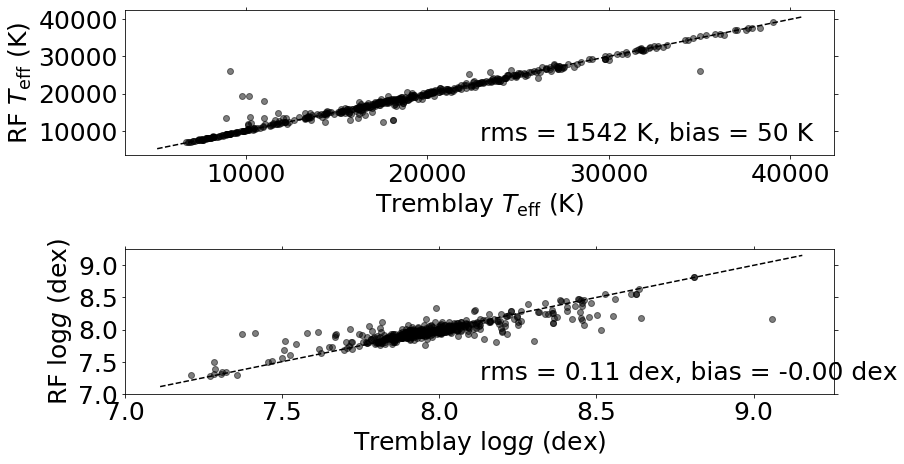

In [31]:
plt.figure(figsize=(13,7))
plt.rcParams.update({'font.size': 25})

f = plt.subplot(211)

plt.scatter(truths[:,0],preds[:,0],color='k',alpha = 0.5)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
plt.plot(x,x,'k--')

resid = preds[:,0] - truths[:,0]
lowteffmask = truths[:,0] < 20000
rms = np.sqrt(np.nanmean(resid[lowteffmask]**2))
bias = np.nanmean(resid)
plt.text(0.5,0.1,'rms = %i K, bias = %i K'%(rms,bias), transform = f.transAxes)
plt.xlabel('Tremblay $T_{\mathrm{eff}}$ (K)')
plt.ylabel('RF $T_{\mathrm{eff}}$ (K)')
f.yaxis.set_ticks(np.arange(10000,41000,10000));
f.xaxis.set_ticks(np.arange(10000,41000,10000));
f.tick_params(top = True,right = True)


f = plt.subplot(212)

plt.scatter(truths[:,1],preds[:,1],color='k', alpha = 0.5)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
plt.plot(x,x,'k--')

resid = preds[:,1] - truths[:,1]
rms = np.sqrt(np.nanmean(resid**2))
bias = np.nanmean(resid)
plt.text(0.5,0.1,'rms = %.2f dex, bias = %.2f dex'%(rms,bias), transform = f.transAxes);
f.tick_params(top = True,right = True)
plt.xlabel('Tremblay $\log{g}$ (dex)')
plt.ylabel('RF $\log{g}$ (dex)')
f.yaxis.set_ticks(np.arange(7,9.1,0.5));
f.xaxis.set_ticks(np.arange(7,9.1,0.5));


plt.tight_layout()

### K-Fold CV

In [22]:
kf = KFold(10)

In [23]:
rf = RandomForestRegressor(n_estimators = 100)
tpreds = np.asarray([]);
lpreds = np.asarray([]);
for train_idx,test_idx in kf.split(X):
    X_train, y_train = X[train_idx], t[train_idx]
    rf.fit(X_train,y_train)
    pred = rf.predict(X[test_idx])
    tpreds = np.hstack((tpreds,pred[:,0]))
    lpreds = np.hstack((lpreds,pred[:,1]))

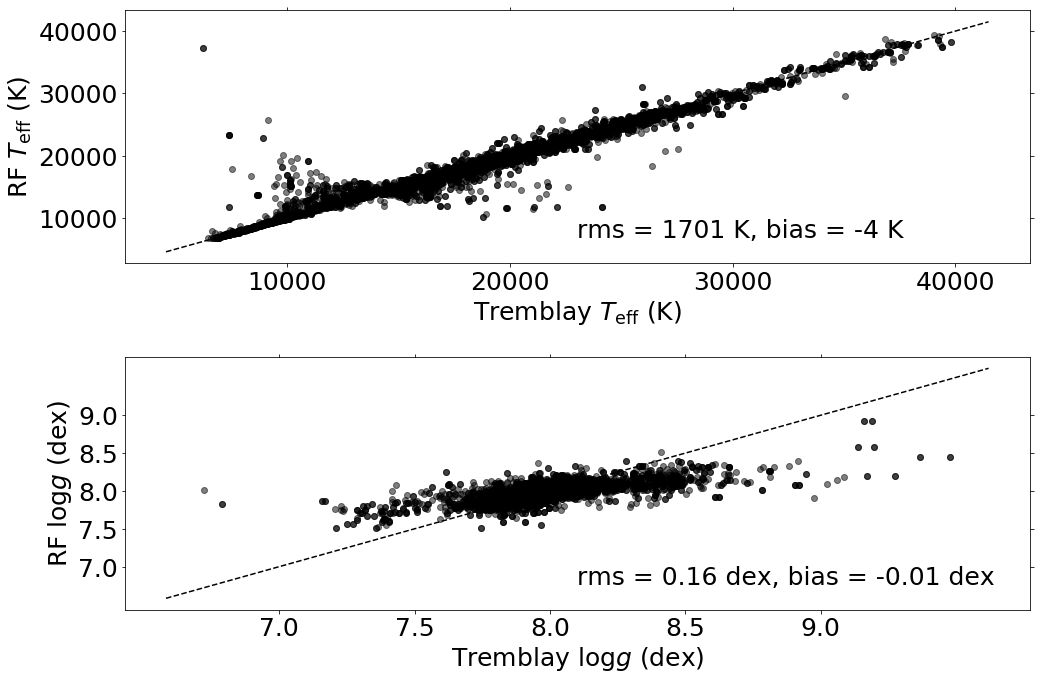

In [24]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 25})

f = plt.subplot(211)

plt.scatter(t[:,0],tpreds,color='k',alpha = 0.5)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
plt.plot(x,x,'k--')

resid = tpreds - t[:,0]
lowteffmask = t[:,0] < 20000
rms = np.sqrt(np.nanmean(resid[lowteffmask]**2))
bias = np.nanmean(resid)
plt.text(0.5,0.1,'rms = %i K, bias = %i K'%(rms,bias), transform = f.transAxes)
plt.xlabel('Tremblay $T_{\mathrm{eff}}$ (K)')
plt.ylabel('RF $T_{\mathrm{eff}}$ (K)')
f.yaxis.set_ticks(np.arange(10000,41000,10000));
f.xaxis.set_ticks(np.arange(10000,41000,10000));
f.tick_params(top = True,right = True)


f = plt.subplot(212)

plt.scatter(t[:,1],lpreds,color='k', alpha = 0.5)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
plt.plot(x,x,'k--')

resid = lpreds - t[:,1]
rms = np.sqrt(np.nanmean(resid**2))
bias = np.nanmean(resid)
plt.text(0.5,0.1,'rms = %.2f dex, bias = %.2f dex'%(rms,bias), transform = f.transAxes);
f.tick_params(top = True,right = True)
plt.xlabel('Tremblay $\log{g}$ (dex)')
plt.ylabel('RF $\log{g}$ (dex)')
f.yaxis.set_ticks(np.arange(7,9.1,0.5));
f.xaxis.set_ticks(np.arange(7,9.1,0.5));


plt.tight_layout()

### Bootstrap/Monte Carlo Errors

In [30]:
from sklearn.utils import resample

In [31]:
X = dfc.drop(labels = ['Teff','logg','chi2_a','chi2_b','chi2_g','center_a','center_b','center_g','Unnamed: 0'], axis = 1)
features = X.columns.to_numpy()
X = np.asarray(X)

t = np.asarray(dfc[['Teff','logg']])

X_train, X_test, y_train, y_test = train_test_split(X,t, test_size = 0.25)

In [32]:
X

array([[1.39099276e-05, 5.99109747e+01, 4.70478107e+01, ...,
        1.56629464e+01, 6.48345638e+01, 5.51713418e-01],
       [1.39099276e-05, 5.99109747e+01, 4.70478107e+01, ...,
        1.56629464e+01, 6.48345638e+01, 5.51713418e-01],
       [1.39099276e-05, 5.99109747e+01, 4.70478107e+01, ...,
        1.56629464e+01, 6.48345638e+01, 5.51713418e-01],
       ...,
       [2.01891665e-02, 4.54241889e+01, 3.80046163e+01, ...,
        2.64851902e+01, 5.29705733e+01, 5.49631161e-01],
       [1.43069794e-03, 4.94858097e+01, 3.97204818e+01, ...,
        1.44170571e+01, 6.75879063e+01, 5.21944484e-01],
       [1.43069794e-03, 4.94858097e+01, 3.97204818e+01, ...,
        1.44170571e+01, 6.75879063e+01, 5.21944484e-01]])

In [33]:
rfs = [];

In [34]:
for i in range(100):
    X_sample, t_sample = resample(X,t, replace = True, n_samples = int(len(X)*0.67))
    rf = RandomForestRegressor(n_estimators = 10)
    rf.fit(X_sample,t_sample)
    rfs.append(rf)

In [51]:
pickle.dump(rfs, open('wdtools/models/bootstrap_rf.p', 'wb'))

In [52]:
tpreds = []
lpreds = []
for bootstrap_rf in rfs:
    pred = bootstrap_rf.predict(X_test)
    tpreds.append(pred[:,0])
    lpreds.append(pred[:,1])
tpreds = np.asarray(tpreds)
lpreds = np.asarray(lpreds)

IndentationError: unexpected indent (<ipython-input-52-ac27a75b2314>, line 3)

In [40]:
tmeans = np.mean(tpreds,0)
tstds = np.std(tpreds,0)
lmeans = np.mean(lpreds,0)
lstds = np.std(lpreds,0)

586


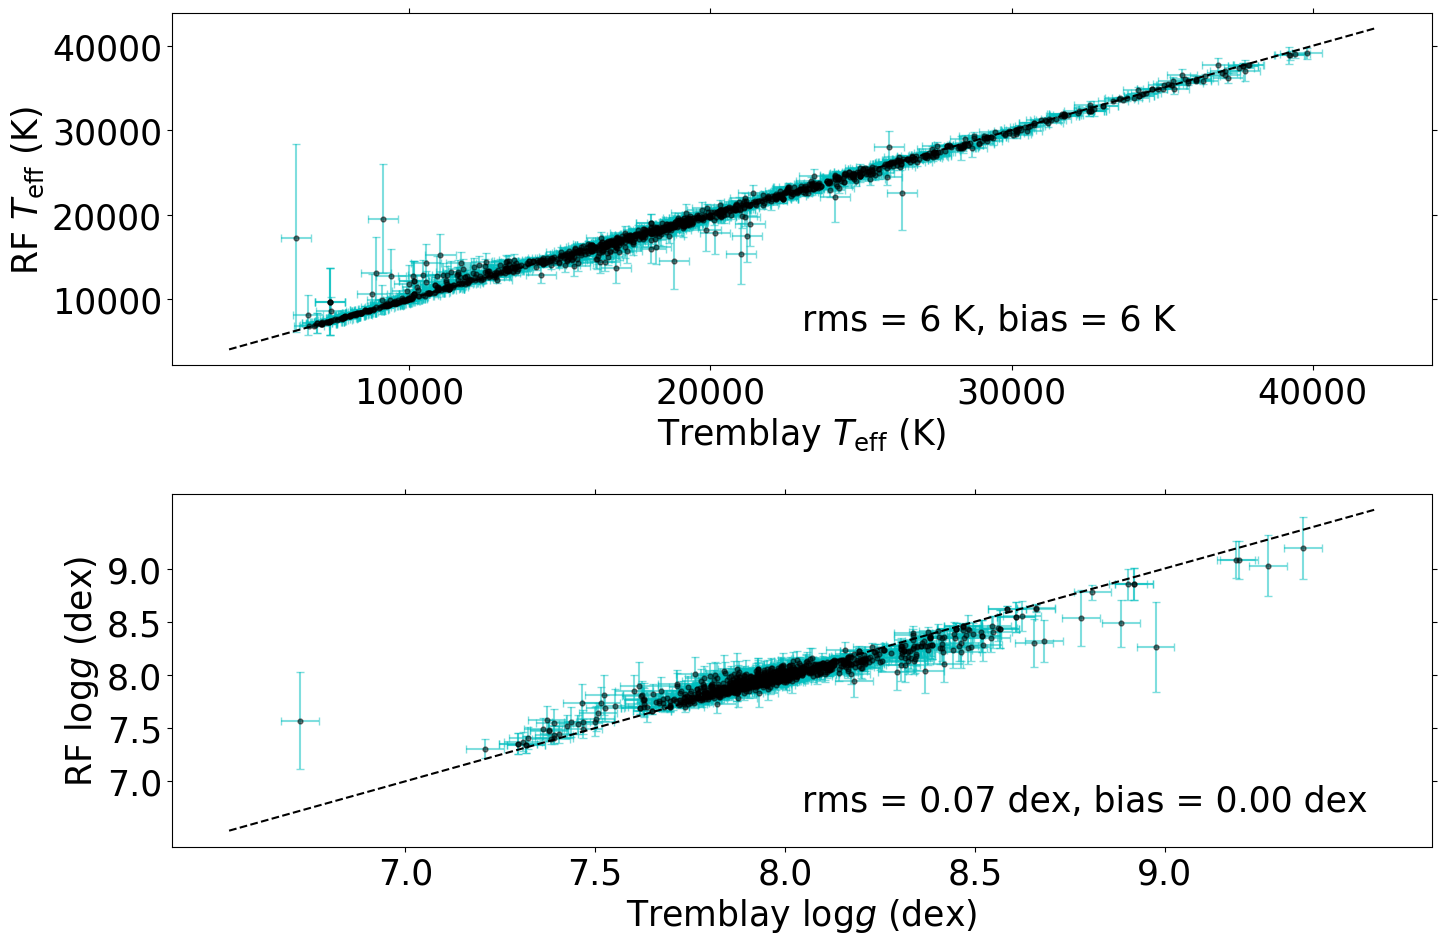

In [41]:
plt.style.use('default')
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 25})


f = plt.subplot(211)
plt.errorbar(y_test[:,0],tmeans,color='k',alpha = 0.5, yerr = tstds,
            linestyle = 'None', marker = '.',\
            ecolor = 'c', capsize = 3, markersize = 7, xerr = np.repeat(500,len(tstds)))
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
plt.plot(x,x,'k--')

resid = tmeans - y_test[:,0]
rms = np.sqrt(np.mean(resid)**2)
bias = np.mean(resid)
plt.text(0.5,0.1,'rms = %i K, bias = %i K'%(rms,bias), transform = f.transAxes)
plt.xlabel('Tremblay $T_{\mathrm{eff}}$ (K)')
plt.ylabel('RF $T_{\mathrm{eff}}$ (K)')
f.yaxis.set_ticks(np.arange(10000,41000,10000));
f.xaxis.set_ticks(np.arange(10000,41000,10000));
f.tick_params(top = True,right = True)
print(np.argmin(np.abs(resid)))

f = plt.subplot(212)

plt.errorbar(y_test[:,1],lmeans,color='k',alpha = 0.5, yerr = lstds,
            linestyle = 'None', marker = '.',\
            ecolor = 'c', capsize = 3, markersize = 7, xerr = np.repeat(0.05,len(tstds)))
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
plt.plot(x,x,'k--')

resid = lmeans - y_test[:,1]
rms = np.sqrt(np.mean(resid**2))
bias = np.mean(resid)
plt.text(0.5,0.1,'rms = %.2f dex, bias = %.2f dex'%(rms,bias), transform = f.transAxes);
f.tick_params(top = True,right = True)
plt.xlabel('Tremblay $\log{g}$ (dex)')
plt.ylabel('RF $\log{g}$ (dex)')
f.yaxis.set_ticks(np.arange(7,9.1,0.5));
f.xaxis.set_ticks(np.arange(7,9.1,0.5));


plt.tight_layout()
plt.savefig('rfpred.pdf')

In [36]:
wdtable

white_dwarf_name_1_1,designation,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,astrometric_excess_noise,astrometric_sigma5d_max,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,l,b,density_1,AG_1,SDSS_name_1_1,umag_1_1,e_umag_1_1,gmag_1_1,e_gmag_1_1,rmag_1_1,e_rmag_1_1,imag_1_1,e_imag_1_1,zmag_1_1,e_zmag_1_1,test_Pwd_1,Pwd_flag_1,Teff_1,eTeff_1,log_g_1,elog_g_1,mass_1,emass_1,chi2_1,Teff_He_1,eTeff_He_1,log_g_He_1,elog_g_He_1,mass_He_1,emass_He_1,chisq_He_1,white_dwarf_name_2_1,SDSS_name_2_1,SDSS_ra_1,SDSS_dec_1,umag_2_1,e_umag_2_1,gmag_2_1,e_gmag_2_1,rmag_2_1,e_rmag_2_1,imag_2_1,e_imag_2_1,zmag_2_1,e_zmag_2_1,Plate_1,mjd_1,fiberID_1,S/N_1,spectral_class_1,specpath,specnames,sigma_a,h3_a,h4_a,ghscale_a,ghcentre_a,sigma_b,h3_b,h4_b,ghscale_b,ghcentre_b,new_bbteff,bbteff,class [1],subclass [1],goodness [1],lgamma_alpha,ggamma_alpha,centre_alpha,scale_alpha,lgamma_beta,ggamma_beta,centre_beta,scale_beta,solution_id,designation_1,random_index,ref_epoch,ra_1,ra_error_1,dec_1,dec_error_1,parallax_1,parallax_error_1,parallax_over_error,pmra_1,pmra_error_1,pmdec_1,pmdec_error_1,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise_1,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max_1,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux_1,phot_g_mean_flux_error_1,phot_g_mean_flux_over_error,phot_g_mean_mag_1,phot_bp_n_obs,phot_bp_mean_flux_1,phot_bp_mean_flux_error_1,phot_bp_mean_flux_over_error,phot_bp_mean_mag_1,phot_rp_n_obs,phot_rp_mean_flux_1,phot_rp_mean_flux_error_1,phot_rp_mean_flux_over_error,phot_rp_mean_mag_1,phot_bp_rp_excess_factor_1,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l_1,b_1,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,u_mag,g_mag,r_mag,i_mag,z_mag,w1mpro,w2mpro,cc_flags,var_flag,j_m,h_m,ks_m,g,abs_g,unit_error,Amp,var_metric_v0,var_metric_v1,abs_sdss_u,abs_sdss_g,abs_sdss_r,abs_sdss_i,abs_sdss_z,abs_w1,abs_w2,abs_j,abs_h,abs_ks,dg,N_spectra,Ha_L_gamma,Ha_L_line_wl,Ha_L_scale,Ha_L_asymmetry_500,Ha_L_asymmetry_1000,Ha_L_asymmetry_2000,Hb_L_gamma,Hb_L_line_wl,Hb_L_scale,Hb_L_asymmetry_500,Hb_L_asymmetry_1000,Hb_L_asymmetry_2000,Ha_asymmetry_500,Ha_asymmetry_1000,Ha_asymmetry_2000,Hb_asymmetry_500,Hb_asymmetry_1000,Hb_asymmetry_2000,usable_spec_count,Ha_vel_diff,Hb_vel_diff,gamma_ratio,tan_velocity,Ha_gamma_d,Ha_scale_d,Hb_gamma_d,Hb_scale_d,N_spec_to_calculate_median_lineprop,Hea_L_gamma,Hea_L_line_wl,Hea_L_scale,Hea_asymmetry_500,Hea_asymmetry_1000,Hea_asymmetry_2000,Heb_L_gamma,Heb_L_line_wl,Heb_L_scale,Heb_asymmetry_500,Heb_asymmetry_1000,Heb_asymmetry_2000,He_usable_spec_count,Sp,WD,Source,RA_ICRS,DE_ICRS,Plx,pmRA,pmDE,Gmag,BPmag,RPmag,SDSS,umag,gmag_lc,rmag,imag,zmag,Pwd,TeffH,loggH,MassH,TeffHe,loggHe,MassHe,_RA_icrs,_DE_icrs,goodflag,white_dwarf_name_1_2,designation_2,ra_2,ra_error_2,dec_2,dec_error_2,parallax_2,parallax_error_2,pmra_2,pmra_error_2,pmdec_2,pmdec_error_2,astrometric_excess_noi

In [80]:
df.to_csv('line_profiles_5366.csv')